In [1]:
!pip -q install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, Subset, DataLoader

from torchvision import transforms, datasets, models
from captum.attr import LayerIntegratedGradients

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_mean = [.485, .456, .406]
data_std = [.229, .224, .225]
image_size = 224

In [3]:
preprocessing = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=preprocessing)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=preprocessing)

100%|██████████| 170M/170M [00:04<00:00, 34.2MB/s] 


In [4]:
class Collector:
    def __init__(self, module):
        self.module = module
        self.activation = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input_, output):
        self.activations = output.detach().cpu()

    def clear(self):
        self.activations = None

    def remove(self):
        self.hook.remove()

def collect_activations(model, loader, layer_module=None, layer_name=None, num_batches=None):
    if not ((layer_module is None) ^ (layer_name is None)):
        raise Exception("should pass layer_module xor layer_name")

    if layer_name:
        layer_module = dict(model.named_modules())[layer_name]

    model.eval()
    device = next(model.parameters()).device
    farmer = Collector(layer_module)
    activations = []
    with torch.no_grad():
        for i, (imgs, _) in enumerate(loader):
            _ = model(imgs.to(device))
            As = farmer.activations
            b, c, = As.shape[:2]
            As = As.view(b, c, -1).mean(dim=2)
            activations.append(As.numpy())
            farmer.clear()
            if num_batches is not None and i == num_batches:
                break
    farmer.remove()
    return np.vstack(activations)

In [5]:
def train_cav(pos_acts, neg_acts):
    x = np.vstack([pos_acts, neg_acts])
    y = np.hstack([np.ones(len(pos_acts)), np.zeros(len(neg_acts))])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train, y_train)
    acc = clf.score(x_test, y_test)
    w = clf.coef_.reshape(-1)
    w = w / (np.linalg.norm(w) + 1e-12)
    return w, acc

In [6]:
def layer_ig_concept_attribution(model, layer_module, inputs, baseline, target, cav,
                                 device):
    lig = LayerIntegratedGradients(model, layer_module)
    attributions_layer = lig.attribute(inputs, baselines=baseline, target=target)
    b = attributions_layer.shape[0]
    c = attributions_layer.shape[1]
    a_l = attributions_layer.view(b, c, -1).mean(dim=2).detach()
    cav = torch.from_numpy(cav).to(a_l.dtype).to(device)
    return (a_l @ cav).sign().mean()

In [7]:
concept_class = 0
target_class = 12
max_samples = 200

pos_idx = np.where(np.array(train_dataset.targets) == concept_class)[0][:max_samples]
pos_dataset = Subset(train_dataset, pos_idx)
pos_loader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=2)

neg_idx = np.where(np.array(train_dataset.targets) != concept_class)[0][:max_samples]
neg_dataset = Subset(train_dataset, neg_idx)
neg_loader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=2)

probe_loader = DataLoader(
    Subset(test_dataset, list(range(200))),
    batch_size=64,
    shuffle=False,
    num_workers=2
)

model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()


layers = [
    (model.layer1, 'layer1'), 
    (model.layer2, 'layer2'),
    (model.layer3, 'layer3'), 
    (model.layer4, 'layer4')
]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s] 


In [8]:
cavs = []
cav_accs = []
layer_names = []
probe_inputs = []

for i, (x, _) in enumerate(probe_loader):
    probe_inputs.append(x)
    if i+1 >= 10:
        break

probe_inputs = torch.cat(probe_inputs, dim=0).to(device)
b, c, h, w, = probe_inputs.shape
baseline = torch.tensor(data_mean).view(1, 3, 1, 1).repeat(1, 1, image_size, image_size).to(device)

In [9]:
trajectories = []
for layer_module, layer_name in layers:
    layer_names.append(layer_name)
    pos_acts = collect_activations(model, pos_loader, layer_module)
    
    neg_acts = collect_activations(model, neg_loader, layer_module)
    w, acc = train_cav(pos_acts, neg_acts)
    cavs.append(w)
    cav_accs.append(acc)

    n = 2
    scores = torch.zeros(1).to(device)
    for chunk in tqdm(range(max_samples // n)):
        slice_ = slice(chunk*n, (chunk+1)*n)
        scores += layer_ig_concept_attribution(model, layer_module, probe_inputs[slice_], baseline,
                                              target_class, w, device)
    trajectories.append(scores / (max_samples // n))

trajectories = [t.item() for t in trajectories]

100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


In [16]:
def plot_trajectory(layer_names, trajectories, cav_accs):
    trajectories = np.array(trajectories)
    n= len(trajectories)

    plt.figure(figsize=(10, 5))
    plt.plot(range(n), trajectories, marker='o')
    plt.plot(range(n), cav_accs, marker='o', color="red")

    plt.xticks(range(n), layer_names)
    plt.title('concept trajectory across selected layers')
    plt.grid(True)
    plt.show()

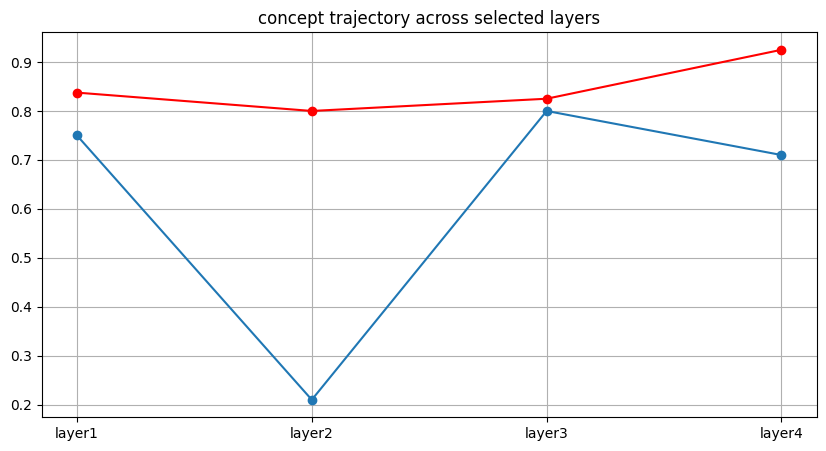

In [17]:
plot_trajectory(layer_names, trajectories, cav_accs)